# Knn on  Amazon Finefood Reviews.

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

Id
ProductId - unique identifier for the product
UserId - unqiue identifier for the user
ProfileName
HelpfulnessNumerator - number of users who found the review helpful
HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
Score - rating between 1 and 5
Time - timestamp for the review
Summary - brief summary of the review
Text - text of the review


In [1]:
#Importing all the necessary packages.
import sqlite3
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [2]:
# Now accesing the database where we have cleaned text. Cleaned Text means, the transformed text which has been Lemmatized, 
#Stemmed,etc. 
conn = sqlite3.connect('C:/Users/Swaroop/Desktop/Srikanth Reddy/final1.sqlite')
final = pd.read_sql_query("""
SELECT *
FROM Reviews
""", conn) 

In [3]:
#Converting the Unix time stamp to human readable form.
final['Time']=(pd.to_datetime(final['Time'],unit='ms')) 

In [4]:
#Here we can see that we have almost3.65lakh reviews.
final.shape


(364171, 12)

In [5]:
# Sorting the reviews accoring to Time stamp in ascending order so that old reviews remain in train and the latest reviews in test.
final2=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
# Since KNN algorithm has memory problem(memory issue occurs if data is large), we will only take 1lakh points from the final2 datafram.
final2=final2[0:100000]
final2['Score'].value_counts()

positive    87729
negative    12271
Name: Score, dtype: int64

In [7]:
#Importing all the necessary packages for performing Knn.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [176]:
# Part I
# ============================== Data Preprocessing ===========================================
#Here we will be performing KNN on only reviews, thats why we take only CleanedText column in X.
#in variable 'y', we keep only Scores(positive,negative) for a the corresponding reviews. 
X = final2.CleanedText.values # end index is exclusive
y = final2.Score.values # showing you two ways of indexing a pandas df
X.shape # We can see that there are 1 lakh reviews(rows)


(100000,)

In [9]:
#X_1 = X[0:80000]
#y_1 = y[0:80000]
#X_test = X[80000:]
#y_test = y[80000:]

In [177]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)

In [181]:
y_train.shape

(80000,)

#### Writing a common fuction.
Writing a common fuction to calculate accuracies and plot misclassification errors and confustion matrix.

In [198]:
def runKNN(X_tr_input,y_tr_input,X_test,y_test,VectorizationType):
    
    cv_scores = []
    cm_list=[]
    algorithm = ['brute','kd_tree']
    for algo in algorithm:
        #print(algo)
        # kd_tree cannot consume Sparse Matrix. Converting Sparse Matrix to Dense using Truncated SVD.
        if algo == 'kd_tree':
            svd = TruncatedSVD()
            X_tr_input1 = svd.fit_transform(X_tr_input)
            #x_cv_input1 = svd.fit_transform(x_cv_input)
            X_test_input1=svd.fit_transform(X_test)
            X_tr_input = X_tr_input1
            #x_cv_input = x_cv_input1
            X_test= X_test_input1
            #print(type(x_cv_input))
 


       # creating odd list of K for KNN
        myList = list(range(0,25))
        neighbors = list(filter(lambda x: x % 2 != 0, myList))

        # empty list that will hold cv scores
        cv_scores = []

        # perform 10-fold cross validation
        for k in neighbors:
            knn = KNeighborsClassifier(n_neighbors=k,algorithm=algo)
            scores = cross_val_score(knn,X_tr_input , y_tr_input, cv=10, scoring='accuracy')
            cv_scores.append(scores.mean())

        # changing to misclassification error
        MSE = [1 - x for x in cv_scores]

        # determining best k
        optimal_k = neighbors[MSE.index(min(MSE))]
        #print('\nThe optimal number of neighbors is %d.' % optimal_k)
        
        knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

        # fitting the model
        knn_optimal.fit(X_tr_input, y_tr_input)

        
        # predict the response
        pred = knn_optimal.predict(X_test)

        # evaluate accuracy
        acc = accuracy_score(y_test, pred) * 100
        #print('\n The accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
        
        print('Details for ',VectorizationType,'Vectorization:')
        print('*'*100)
        print('\n')
        print('Accuracy for',algo,' algorithm with K =',optimal_k,' is ' ,np.round(accuracy_score(y_test, pred)*100))
        
        # plot misclassification error vs k 
        plt.plot(neighbors, MSE)

        for xy in zip(neighbors, np.round(MSE,3)):
            plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

        plt.xlabel('Number of Neighbors K')
        plt.ylabel('Misclassification Error')
        plt.show()

        print("The misclassification error for each k value is : ", np.round(MSE,3))
        cm = confusion_matrix(y_test, pred)
        class_label = ["negative", "positive"]
        df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
        sns.heatmap(df_cm, annot = True, fmt = "d")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
    return knn_optimal

### Bag of Words on Train and Test.

In [183]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_train) # Here we fit transform to the data

bow_train.get_shape() # We can see that the data has 80k rows and 33491 columns(unique words).


(80000, 33491)

In [13]:
#bow_cv=count_vect.transform(X_cv)
#bow_cv.get_shape()

(24000, 28402)

In [184]:
bow_test=count_vect.transform(X_test) # Transforming the test data.
bow_test.get_shape()

(20000, 33491)

Details for  Bag Of Words Vectorization:
****************************************************************************************************


Accuracy for brute  algorithm with K = 9  is  88.0


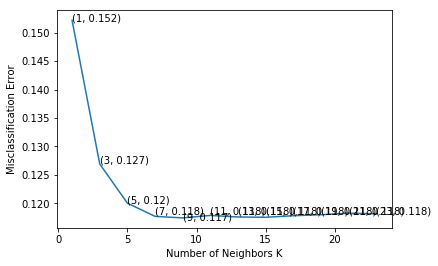

The misclassification error for each k value is :  [0.152 0.127 0.12  0.118 0.117 0.118 0.118 0.118 0.118 0.118 0.118 0.118]


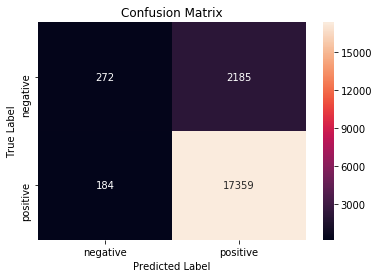

Details for  Bag Of Words Vectorization:
****************************************************************************************************


Accuracy for kd_tree  algorithm with K = 23  is  88.0


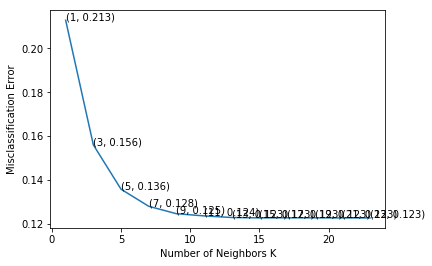

The misclassification error for each k value is :  [0.213 0.156 0.136 0.128 0.125 0.124 0.123 0.123 0.123 0.123 0.123 0.123]


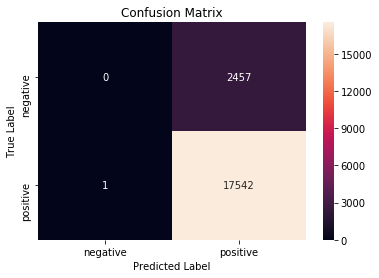

Wall time: 36min


In [187]:
#Calling the function with parameters
%%time
bow_optimal_k=runKNN(bow_train,y_train,bow_test,y_test,'Bag Of Words')

### KNN on Tf-Idf  

In [199]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [200]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_train)
tfidf_train.shape

(80000, 1016927)

In [201]:
#tfidf_cv=tf_idf_vect.transform(X_cv)
#tfidf_cv.shape

(24000, 1016927)

In [204]:
tfidf_test=tf_idf_vect.transform(X_test)


Details for  TFIDF Vectorization:
****************************************************************************************************


Accuracy for brute  algorithm with K = 7  is  89.0


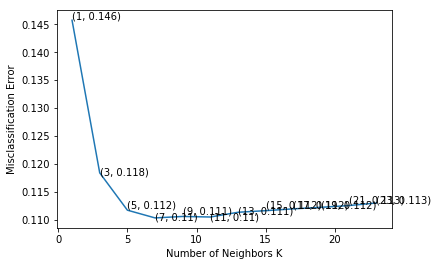

The misclassification error for each k value is :  [0.146 0.118 0.112 0.11  0.111 0.11  0.111 0.112 0.112 0.112 0.113 0.113]


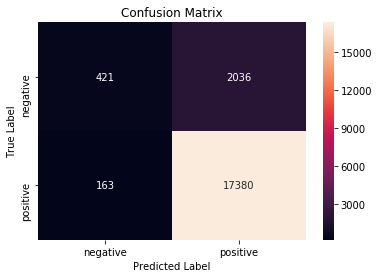

Details for  TFIDF Vectorization:
****************************************************************************************************


Accuracy for kd_tree  algorithm with K = 23  is  88.0


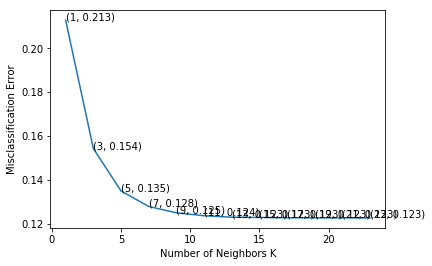

The misclassification error for each k value is :  [0.213 0.154 0.135 0.128 0.125 0.124 0.123 0.123 0.123 0.123 0.123 0.123]


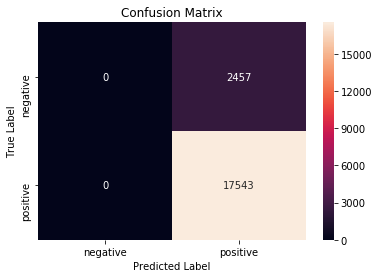

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=23, p=2,
           weights='uniform')

In [205]:
runKNN(tfidf_train,y_train,tfidf_test,y_test,'TFIDF')

### AVG Word 2 Vector

In [206]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim

In [207]:
# We are suppose to find a list of list where each list is a sentence and we use this list to train W2V.
#Since our X_train is a numpy multimentional array having sentence in bytes, we have to convert the byte 
#objects and convert to string.
# In this way we create list of list using X_train and we will train W2V using it.
list_of_train=[]
for i in X_train:
    decode=i.decode('utf-8')#Since the data in X_train is of byte type, we convert it into string.
    text =decode.split()    # Now we create a list of sentence 
    list_of_train.append(text)# Here we append everything so that we get a list 
print(list_of_train)           #of list where each list is sentence.

#We follow the same process for X_cv also.
#list_of_cv=[]
#for i in X_cv:
#    decode=i.decode('utf-8')
#    text =decode.split() 
#    list_of_cv.append(text)
#print(list_of_cv)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [208]:
list_of_test=[]
for i in X_test:
    decode=i.decode('utf-8')
    text =decode.split() 
    list_of_test.append(text)
print(list_of_test)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [209]:
#We train our W2V model only using X_train list and try to find 
#avgW2V for train, test and cv datasets.
w2v_model=gensim.models.Word2Vec(list_of_train,min_count=5,size=50, workers=6)  

In [210]:
w2v= w2v_model[w2v_model.wv.vocab]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [211]:
w2v.shape

(11373, 50)

In [212]:
type(w2v)

numpy.ndarray

In [213]:
w2v_words = list(w2v_model.wv.vocab)


### Average W2V

In [214]:
#Creating a function for AVGw2v
def AVGw2v(x):
    sent_vectors = [];           # the avg-w2v for each sentence/review is stored in this list
    for sent in x:    # for each review/sentence
        sent_vec = np.zeros(50)  # as word vectors are of zero length
        cnt_words =0;            # num of words with a valid vector in the sentence/review
        for word in sent:        # for each word in a review/sentence
            try:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [215]:
avgW2V_train= AVGw2v(list_of_train)
#avgW2V_cv = AVGw2v(list_of_cv)

In [216]:
avgW2V_test=AVGw2v(list_of_test)

Details for  AVGW2V Vectorization:
****************************************************************************************************


Accuracy for brute  algorithm with K = 11  is  90.0


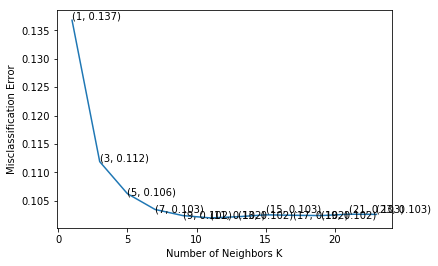

The misclassification error for each k value is :  [0.137 0.112 0.106 0.103 0.102 0.102 0.102 0.103 0.102 0.102 0.103 0.103]


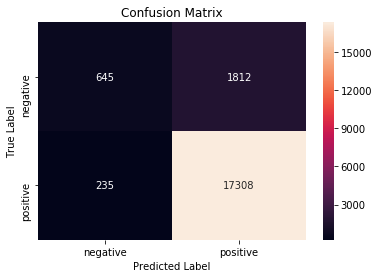

Details for  AVGW2V Vectorization:
****************************************************************************************************


Accuracy for kd_tree  algorithm with K = 21  is  88.0


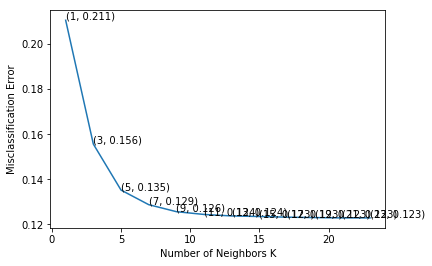

The misclassification error for each k value is :  [0.211 0.156 0.135 0.129 0.126 0.124 0.124 0.123 0.123 0.123 0.123 0.123]


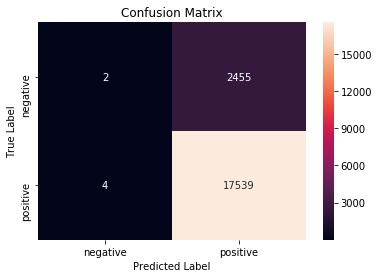

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=21, p=2,
           weights='uniform')

In [217]:
runKNN(avgW2V_train,y_train,avgW2V_test,y_test,'AVGW2V')

### TFIDFW2V

In [218]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictonary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [219]:
tf_idf_vect1 = TfidfVectorizer(ngram_range=(1,2))
tfidf_test = tf_idf_vect1.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictonary1 = dict(zip(tf_idf_vect1.get_feature_names(), list(tf_idf_vect1.idf_)))

In [167]:
#tf_idf_vect2 = TfidfVectorizer(ngram_range=(1,2))
#tfidf_cv = tf_idf_vect2.fit_transform(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
#dictonary2 = dict(zip(tf_idf_vect2.get_feature_names(), list(tf_idf_vect2.idf_)))

In [220]:
# TF-IDF weighted Word2Vec
from tqdm import tqdm

def tfidf_w2v(x,y):
    
    tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = [] # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(x): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]# 50dim array is created for each word in the list of train(x).
                # obtain the tf_idfidf of a word in a sentence/review
                #tfi_df = final_tf_idf[row, tfidf_feat.index(word)]
                tf_idf = y[word]*(sent.count(word)/len(sent)) #here we get the tfidf value of the word from the list of train
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [221]:
tfidfw2v_train=tfidf_w2v(list_of_train,dictonary)





  0%|                                                                                        | 0/80000 [00:00<?, ?it/s]



  0%|▏                                                                           | 193/80000 [00:00<00:41, 1915.50it/s]



  0%|▎                                                                           | 359/80000 [00:00<00:43, 1814.60it/s]



  1%|▍                                                                           | 509/80000 [00:00<00:46, 1702.92it/s]



  1%|▋                                                                           | 680/80000 [00:00<00:46, 1696.32it/s]



  1%|▊                                                                           | 828/80000 [00:00<00:48, 1621.15it/s]



  1%|▉                                                                           | 996/80000 [00:00<00:48, 1634.85it/s]



  1%|█                                                                          | 1162/80000 [00:00<00:48, 1638.93it/s]



  2%|█▏     

 23%|█████████████████▏                                                        | 18576/80000 [00:13<00:45, 1363.74it/s]



 23%|█████████████████▎                                                        | 18718/80000 [00:14<00:45, 1353.64it/s]



 24%|█████████████████▍                                                        | 18854/80000 [00:14<00:45, 1352.59it/s]



 24%|█████████████████▌                                                        | 18993/80000 [00:14<00:44, 1360.70it/s]



 24%|█████████████████▋                                                        | 19139/80000 [00:14<00:43, 1386.16it/s]



 24%|█████████████████▊                                                        | 19279/80000 [00:14<00:43, 1387.27it/s]



 24%|█████████████████▉                                                        | 19418/80000 [00:14<00:47, 1278.44it/s]



 24%|██████████████████                                                        | 19548/80000 [00:14<00:47, 1278.20it/s]



 25%|███████████

 46%|█████████████████████████████████▉                                        | 36734/80000 [00:28<00:35, 1205.36it/s]



 46%|██████████████████████████████████                                        | 36858/80000 [00:28<00:35, 1209.41it/s]



 46%|██████████████████████████████████▏                                       | 36980/80000 [00:28<00:35, 1202.80it/s]



 46%|██████████████████████████████████▎                                       | 37121/80000 [00:28<00:34, 1255.91it/s]



 47%|██████████████████████████████████▍                                       | 37252/80000 [00:28<00:33, 1268.87it/s]



 47%|██████████████████████████████████▌                                       | 37380/80000 [00:28<00:33, 1269.43it/s]



 47%|██████████████████████████████████▋                                       | 37515/80000 [00:28<00:32, 1289.87it/s]



 47%|██████████████████████████████████▊                                       | 37645/80000 [00:28<00:37, 1138.03it/s]



 47%|███████████

 68%|██████████████████████████████████████████████████▋                       | 54800/80000 [00:42<00:18, 1384.72it/s]



 69%|██████████████████████████████████████████████████▊                       | 54939/80000 [00:42<00:20, 1229.53it/s]



 69%|██████████████████████████████████████████████████▉                       | 55084/80000 [00:42<00:19, 1285.78it/s]



 69%|███████████████████████████████████████████████████                       | 55238/80000 [00:42<00:18, 1346.66it/s]



 69%|███████████████████████████████████████████████████▏                      | 55389/80000 [00:42<00:17, 1385.22it/s]



 69%|███████████████████████████████████████████████████▍                      | 55547/80000 [00:42<00:17, 1435.56it/s]



 70%|███████████████████████████████████████████████████▌                      | 55693/80000 [00:42<00:18, 1322.63it/s]



 70%|███████████████████████████████████████████████████▋                      | 55829/80000 [00:42<00:19, 1271.20it/s]



 70%|███████████

 91%|███████████████████████████████████████████████████████████████████▌      | 73058/80000 [00:56<00:04, 1392.66it/s]



 92%|███████████████████████████████████████████████████████████████████▋      | 73200/80000 [00:56<00:05, 1218.34it/s]



 92%|███████████████████████████████████████████████████████████████████▊      | 73330/80000 [00:56<00:05, 1239.15it/s]



 92%|███████████████████████████████████████████████████████████████████▉      | 73468/80000 [00:56<00:05, 1275.71it/s]



 92%|████████████████████████████████████████████████████████████████████      | 73603/80000 [00:56<00:04, 1290.69it/s]



 92%|████████████████████████████████████████████████████████████████████▏     | 73764/80000 [00:56<00:04, 1366.31it/s]



 92%|████████████████████████████████████████████████████████████████████▎     | 73907/80000 [00:56<00:04, 1378.02it/s]



 93%|████████████████████████████████████████████████████████████████████▍     | 74047/80000 [00:56<00:04, 1345.79it/s]



 93%|███████████

In [222]:
#tfidfw2v_cv=tfidf_w2v(list_of_cv,dictonary2)

In [223]:
tfidfw2v_test=tfidf_w2v(list_of_test,dictonary1)





  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]



  1%|▌                                                                           | 134/20000 [00:00<00:14, 1330.31it/s]



  1%|▉                                                                           | 259/20000 [00:00<00:15, 1302.17it/s]



  2%|█▌                                                                          | 405/20000 [00:00<00:14, 1343.12it/s]



  3%|██                                                                          | 546/20000 [00:00<00:14, 1355.72it/s]



  3%|██▌                                                                         | 682/20000 [00:00<00:14, 1354.05it/s]



  4%|███                                                                         | 806/20000 [00:00<00:14, 1314.63it/s]



  5%|███▌                                                                        | 941/20000 [00:00<00:14, 1322.21it/s]



  5%|████   

 91%|███████████████████████████████████████████████████████████████████▎      | 18188/20000 [00:14<00:01, 1264.34it/s]



 92%|███████████████████████████████████████████████████████████████████▊      | 18317/20000 [00:14<00:01, 1218.95it/s]



 92%|████████████████████████████████████████████████████████████████████▎     | 18448/20000 [00:14<00:01, 1238.82it/s]



 93%|████████████████████████████████████████████████████████████████████▋     | 18574/20000 [00:14<00:01, 1238.76it/s]



 94%|█████████████████████████████████████████████████████████████████████▏    | 18715/20000 [00:14<00:01, 1283.13it/s]



 94%|█████████████████████████████████████████████████████████████████████▋    | 18845/20000 [00:14<00:00, 1230.66it/s]



 95%|██████████████████████████████████████████████████████████████████████▏   | 18970/20000 [00:14<00:00, 1142.63it/s]



 96%|██████████████████████████████████████████████████████████████████████▋   | 19107/20000 [00:14<00:00, 1200.18it/s]



 96%|███████████

Details for  TfidfW2V Vectorization:
****************************************************************************************************


Accuracy for brute  algorithm with K = 17  is  88.0


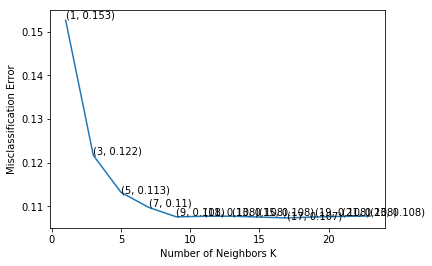

The misclassification error for each k value is :  [0.153 0.122 0.113 0.11  0.108 0.108 0.108 0.108 0.107 0.108 0.108 0.108]


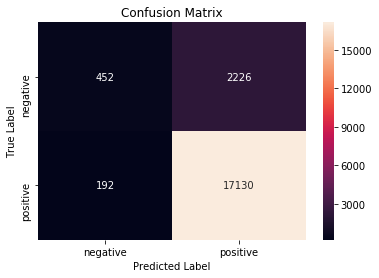

Details for  TfidfW2V Vectorization:
****************************************************************************************************


Accuracy for kd_tree  algorithm with K = 21  is  87.0


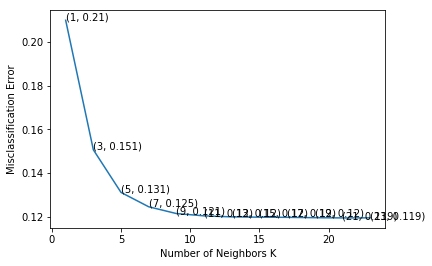

The misclassification error for each k value is :  [0.21  0.151 0.131 0.125 0.121 0.12  0.12  0.12  0.12  0.12  0.119 0.119]


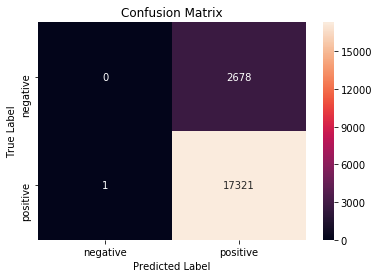

Wall time: 10min 38s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=21, p=2,
           weights='uniform')

In [171]:
%%time
runKNN(tfidfw2v_train,y_train,tfidfw2v_test,y_test,'TfidfW2V')

### Visualizing the Final Result.

In [225]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Name", "Hyper Parameter(k): Brute Force","Hyper Parameter(k): kd-Tree", "Accuracy- Brute Foce", "Accuracy- kd-Tree"]


In [227]:
x.add_row(["Knn on BoW",9,23,88,88])
x.add_row(["Knn on TfIdf",7,23,89,88])
x.add_row(["Knn on AvgW2v",11,21,90,88])
x.add_row(["Knn on TfidfW2V",17,21,88,87])
print(x)

+-----------------+---------------------------------+-----------------------------+----------------------+-------------------+
|    Model Name   | Hyper Parameter(k): Brute Force | Hyper Parameter(k): kd-Tree | Accuracy- Brute Foce | Accuracy- kd-Tree |
+-----------------+---------------------------------+-----------------------------+----------------------+-------------------+
|    Knn on BoW   |                9                |              23             |          88          |         88        |
|    Knn on BoW   |                9                |              23             |          88          |         88        |
|   Knn on TfIdf  |                7                |              23             |          89          |         88        |
|  Knn on AvgW2v  |                11               |              21             |          90          |         88        |
| Knn on TfidfW2V |                17               |              21             |          88          |     